## Characters verticalizer

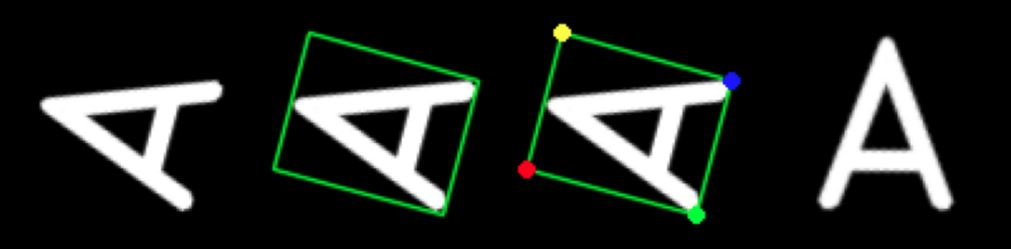

In this free-standing practical exercise I implement the functional of contours (i.e. characters) vertical alignment  for example, for further OCR'ing.

I use a fairly simple algorithm: the script finds contours on the image and calculates the smallest possible rotated bounding rectangle. Then the correction angle is calculated by the slope of the left side of this rectangle.<br>

The left side is chosen as the most universal for Latin characters and numbers. This implementation may not work correctly for some "asymmetric" characters in some fonts and angles (e.g., ```4``` or ```J```), but at the same time, the script should not cause more distortion than it originally was.<br>

*As it was designed to work with MNIST like datasets, the script expect grayscale inverted image at the input*

### Content
#### 1. Sample image generation
#### 2. Detailed implementation and visualization
#### 3. Brief implementation
#### 4. Test

In [1]:
!pip install imutils
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=3739c4eb68fb56cbcd802df8ccf07b6fa987f4695449b4382c501910fcea4b3c
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


#### Helper function to show image(s) by matplotlib

In [2]:
def show(image,H = 5, W = 5):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()
    
    
def show_multi (imgs, H=5, W=5):
    stack = imgs[0]
    for i in range(1, len(imgs)):
        stack = np.hstack((stack, imgs[i]))
    show(stack, H, W)

### 1. Sample image generation
#### Function to generate rotated image

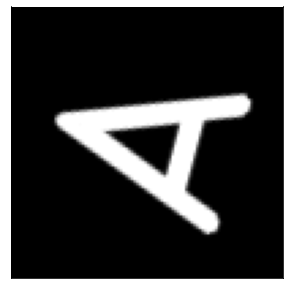

In [3]:
def gen_img(TEXT, ANGLE):
    image = np.zeros((100, 100), np.uint8)
    cv2.putText(image, TEXT,
                (20,80),
                fontFace = cv2.FONT_HERSHEY_DUPLEX,
                fontScale = 3,
                color = 255,
                thickness = 3,
                lineType = cv2.LINE_AA)

    image = imutils.rotate(image, ANGLE)
    return image, ANGLE

img, ANGLE = gen_img('A', 75)
show(img)

### 2. Detailed implementation and visualization

Was originally angled on: -75.5
Corrected on: 75


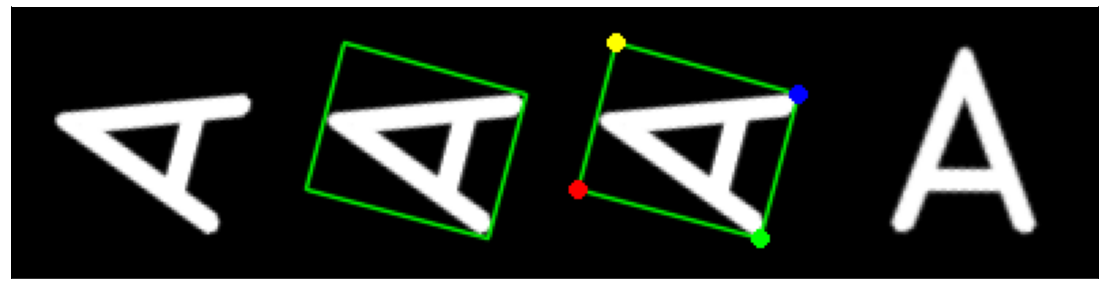

In [4]:
copy = img.copy()

#Find contours
cnts = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

#Keep only the largest one and approximate it
cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
perim = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, 5 * 1e-4 * perim, True)

#Calculate minimal area rectangle
rect = cv2.minAreaRect(approx)
box = cv2.boxPoints(rect)
box = np.int0(box)

#Draw minArea rectangle in color
color = cv2.cvtColor(copy, cv2.COLOR_GRAY2BGR)
contour = cv2.drawContours(color.copy(), [box], -1,
                           (0, 255, 0), 1,lineType = cv2.LINE_AA)

vertices = contour.copy()

#Sort rectangle points by X coordinates
left = box[np.lexsort(np.fliplr(box.copy()).T)]
pt1 = left[0]
pt2 = left[1]
pt3 = left[2]
pt4 = left[3]


#Rectangle vertices drawing
#Red point - leftmost
cv2.circle(vertices, (pt1[0], pt1[1]), 2, (0, 0, 255), 2)
#Yellow point - second from left
cv2.circle(vertices, (pt2[0], pt2[1]), 2, (0, 255, 255), 2)
#Green point - second from right
cv2.circle(vertices, (pt3[0], pt3[1]), 2, (0, 255, 0), 2)
#Blue point - rightmost
cv2.circle(vertices, (pt4[0], pt4[1]), 2, (255, 0, 0), 2)


# Horizontal distance between two left (red and yellow) points
dX = pt1[0] - pt2[0]
# Vertical distance between two left (red and yellow) points
dY = pt1[1] - pt2[1]

#Angle calculation
angle = np.arctan(dX / dY) # Radians
angle = np.degrees(angle) * -1 # multiply by -1 to CORRECT angle

#Force in vertical position
#Euclidian distance calculation to correct if horizontally oriented
heigth = np.linalg.norm(pt1 - pt2)
width = np.linalg.norm(pt1 - pt3)
if width > heigth:
    #Correct angle using the angle sign for CW/CCW detection
    angle -= 90 * np.sign(angle)

#Correction applying
rotated = imutils.rotate(color, angle)

print('Was originally angled on:', round(angle,1))
print('Corrected on:', ANGLE)
show_multi ([color, contour, vertices, rotated], H=20)

### 3. Brief implementation (the same code as a function)

In [5]:
def contour_vert(img):
    copy = img.copy()
    cnts = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    perim = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 5 * 1e-4 * perim, True)
    rect = cv2.minAreaRect(approx)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    #Sort points by X coordinates
    left = box[np.lexsort(np.fliplr(box.copy()).T)]
    pt1 = left[0]
    pt2 = left[1]
    pt3 = left[2]
    pt4 = left[3]

    # Horizontal and vertical distances between two left points
    dX = pt1[0] - pt2[0]
    dY = pt1[1] - pt2[1]

    #Angle calculation
    angle = np.arctan(dX / dY) # Radians
    angle = np.degrees(angle) * -1 # multiply by -1 to CORRECT by angle

    #Force in vertical position
    #Euclidian distance calculation to correct if horizontally oriented
    heigth = np.linalg.norm(pt1 - pt2)
    width = np.linalg.norm(pt1 - pt3)
    if width > heigth:
        angle -= 90 * np.sign(angle)

    #Correction
    rotated = imutils.rotate(copy, angle)

    return rotated

### 4. Test

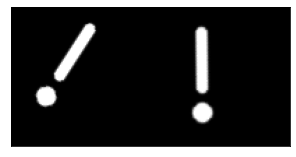

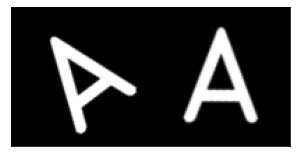

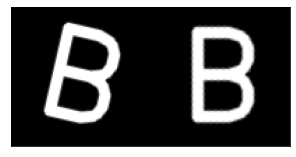

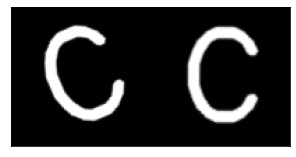

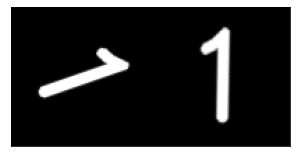

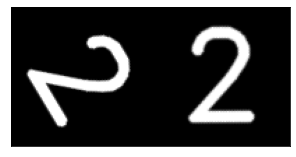

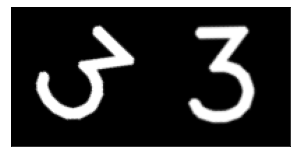

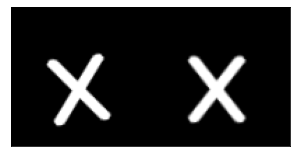

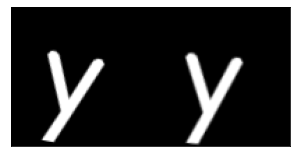

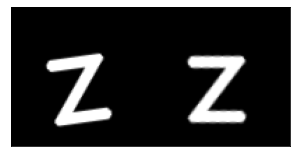

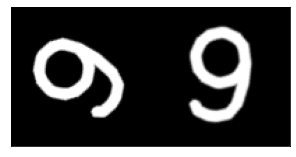

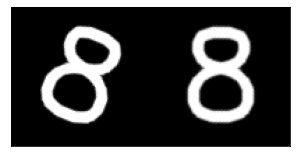

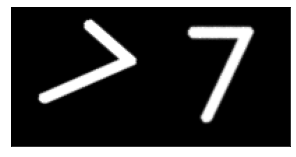

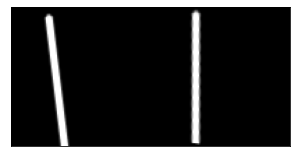

In [6]:
text = '!ABC123xyz987|'
np.random.seed(0)

for i in range(len(text)):
    TEXT = text[i]
    ANGLE = np.random.randint(-80, 80)
    img, _ = gen_img(TEXT, ANGLE)
    corrected = contour_vert(img)
    show_multi([img, corrected])

Not ideally for all sybols, espesially for ```y``` and ```9``` , but correction is not completely well but most importantly not worse than original.<br>
Hopefully sometimes this can help with OCR.<br>
#### Thank you for your attention !